In [1]:
import pickle as pkl
import pandas as pd
import numpy as np
from transformers import CLIPTokenizerFast
import torch

In [2]:
diva_df = pkl.load(open("../clipData/articleData.pkl", "rb"))

In [20]:
uid2name = {v:k for k_l, v_l in zip(diva_df.UidList,diva_df.NameList) for v,k in zip(k_l, v_l)} 
name2uid = {v:k for k, v in uid2name.items()}

In [21]:
pkl.dump(uid2name, open("../clipData/uid2name.pkl", "wb"))
pkl.dump(name2uid, open("../clipData/name2uid.pkl", "wb"))

In [24]:
data = list()
for i, row in diva_df.iterrows():
    for uid in row.UidList:
        data.append([uid, uid2name[uid]] + list(row.values))
    

In [25]:
df = pd.DataFrame(data, columns=["user_id", "name"] + list(row.index))

In [26]:
mask = df.user_id.value_counts() > 5
ix = df.user_id.value_counts()[mask].index
df = df[df.user_id.isin(ix)]

<AxesSubplot:>

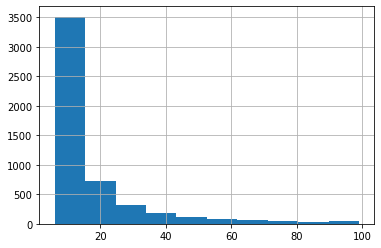

In [27]:
mask = df.user_id.value_counts()< 100
df.user_id.value_counts()[mask].hist()

<AxesSubplot:>

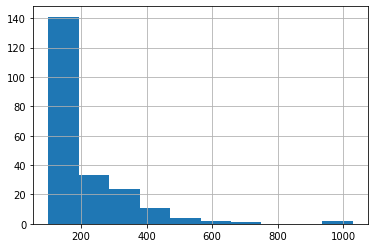

In [28]:
mask = df.user_id.value_counts()>= 100
df.user_id.value_counts()[mask].hist()

In [29]:
uid2i = {uid: i for i,uid in enumerate(df.user_id.unique())}
i2uid = {i: uid for uid, i in uid2i.items()}

pkl.dump(uid2i, open("../clipData/uid2i.pkl", "wb"))
pkl.dump(i2uid, open("../clipData/i2uid.pkl", "wb"))

In [30]:
df["i"] = df.user_id.apply(lambda x: uid2i[x])

In [31]:
pct = 0.2
np.random.seed(42)
df_test_list = list()
df_train_list = list()
for user in set(df.user_id):
    
    df_user = df[df.user_id == user]


    indices = list(df_user.index)
    test_indices = np.random.choice(df_user.index,
                                        size=int(len(df_user.index)*pct),
                                        replace=False)
    train_indicies = list(set(indices) - set(test_indices))

    df_test_part = df_user.loc[test_indices]
    df_train_part = df_user.loc[train_indicies]


    assert not df_train_part.isin(df_test_part).all(1).all(), print(train_indicies, test_indices)
        
    
    
    df_test_list.append(df_test_part)
    df_train_list.append(df_train_part)

In [32]:
df_train = pd.concat(df_train_list)
df_test = pd.concat(df_test_list)

In [33]:
df.to_csv("../clipData/whole.csv")
df_train.to_csv("../clipData/train.csv")
df_test.to_csv("../clipData/test.csv")

In [14]:
tokenizer = CLIPTokenizerFast.from_pretrained("openai/clip-vit-base-patch32")


In [15]:
train_encodings = tokenizer(list(df_train.Abstract), truncation=True, padding=True)
test_encodings = tokenizer(list(df_test.Abstract), truncation=True, padding=True)


In [16]:
train_uids = list(df_train.i)
test_uids = list(df_test.i)

train_doc_id = list(df_train.PID)
test_doc_id = list(df_test.PID)



In [17]:
class RankingDataset(torch.utils.data.Dataset):
    def __init__(self, encodings1, user_id, doc_id):
        self.encodings1 = encodings1
        self.user_id = user_id
        self.doc_id = doc_id

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings1.items()}
        item['user_id'] = torch.tensor(self.user_id[idx])
        item['doc_id'] = torch.tensor(self.doc_id[idx])
        return item

    def __len__(self):
        return len(self.user_id)

In [18]:
train_dataset = RankingDataset(train_encodings, train_uids, train_doc_id)
test_dataset = RankingDataset(test_encodings, test_uids, test_doc_id)

In [19]:
pkl.dump(train_dataset, open("../clipData/rankingDataset/train_dataset.pkl", "wb"))
pkl.dump(test_dataset, open("../clipData/rankingDataset/test_dataset.pkl", "wb"))